Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. Grover’s algorithm was the first to demonstrate this speedup on unstructured search problems.

Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.



In [1]:
# Built-in modules
import math
import warnings

warnings.filterwarnings("ignore")

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [3]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token="340f0988ee08967d19be380d6bd213d8d4ff3ee0fe657cd3154f70abc42c1568fdd485cc84a0caa0a658e61d03c13f5f1e6838f6ea9bf2aa2b87cf8cd840b676")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Step 1: Map classical inputs to a quantum problem

* We define an oracle that marks one or more input basis states defined through their bit-string representation. 
* The MCMT gate is used to implement the multi-controlled Z-gate.
* Grover's algorithm requires an oracle that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.

### Create Oracle for Grover algorithm

In [4]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

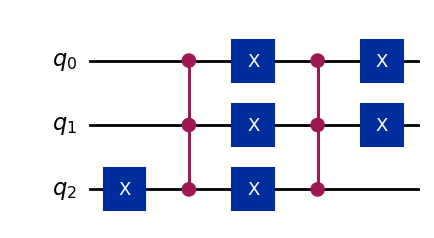

In [5]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

## Grover Operator

The built-in Qiskit GroverOperator takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle. Here, we decompose the circuit to see the gates within the operator:

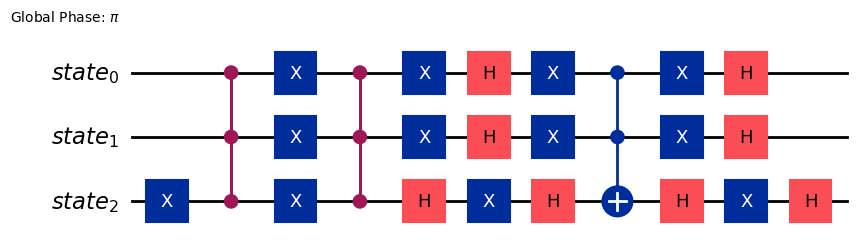

In [6]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this grover_op circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit. There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:

In [7]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

### Full Grover Circuit

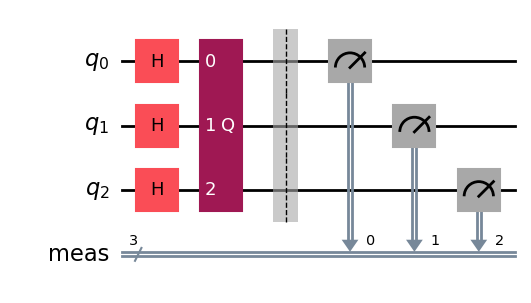

In [8]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution.

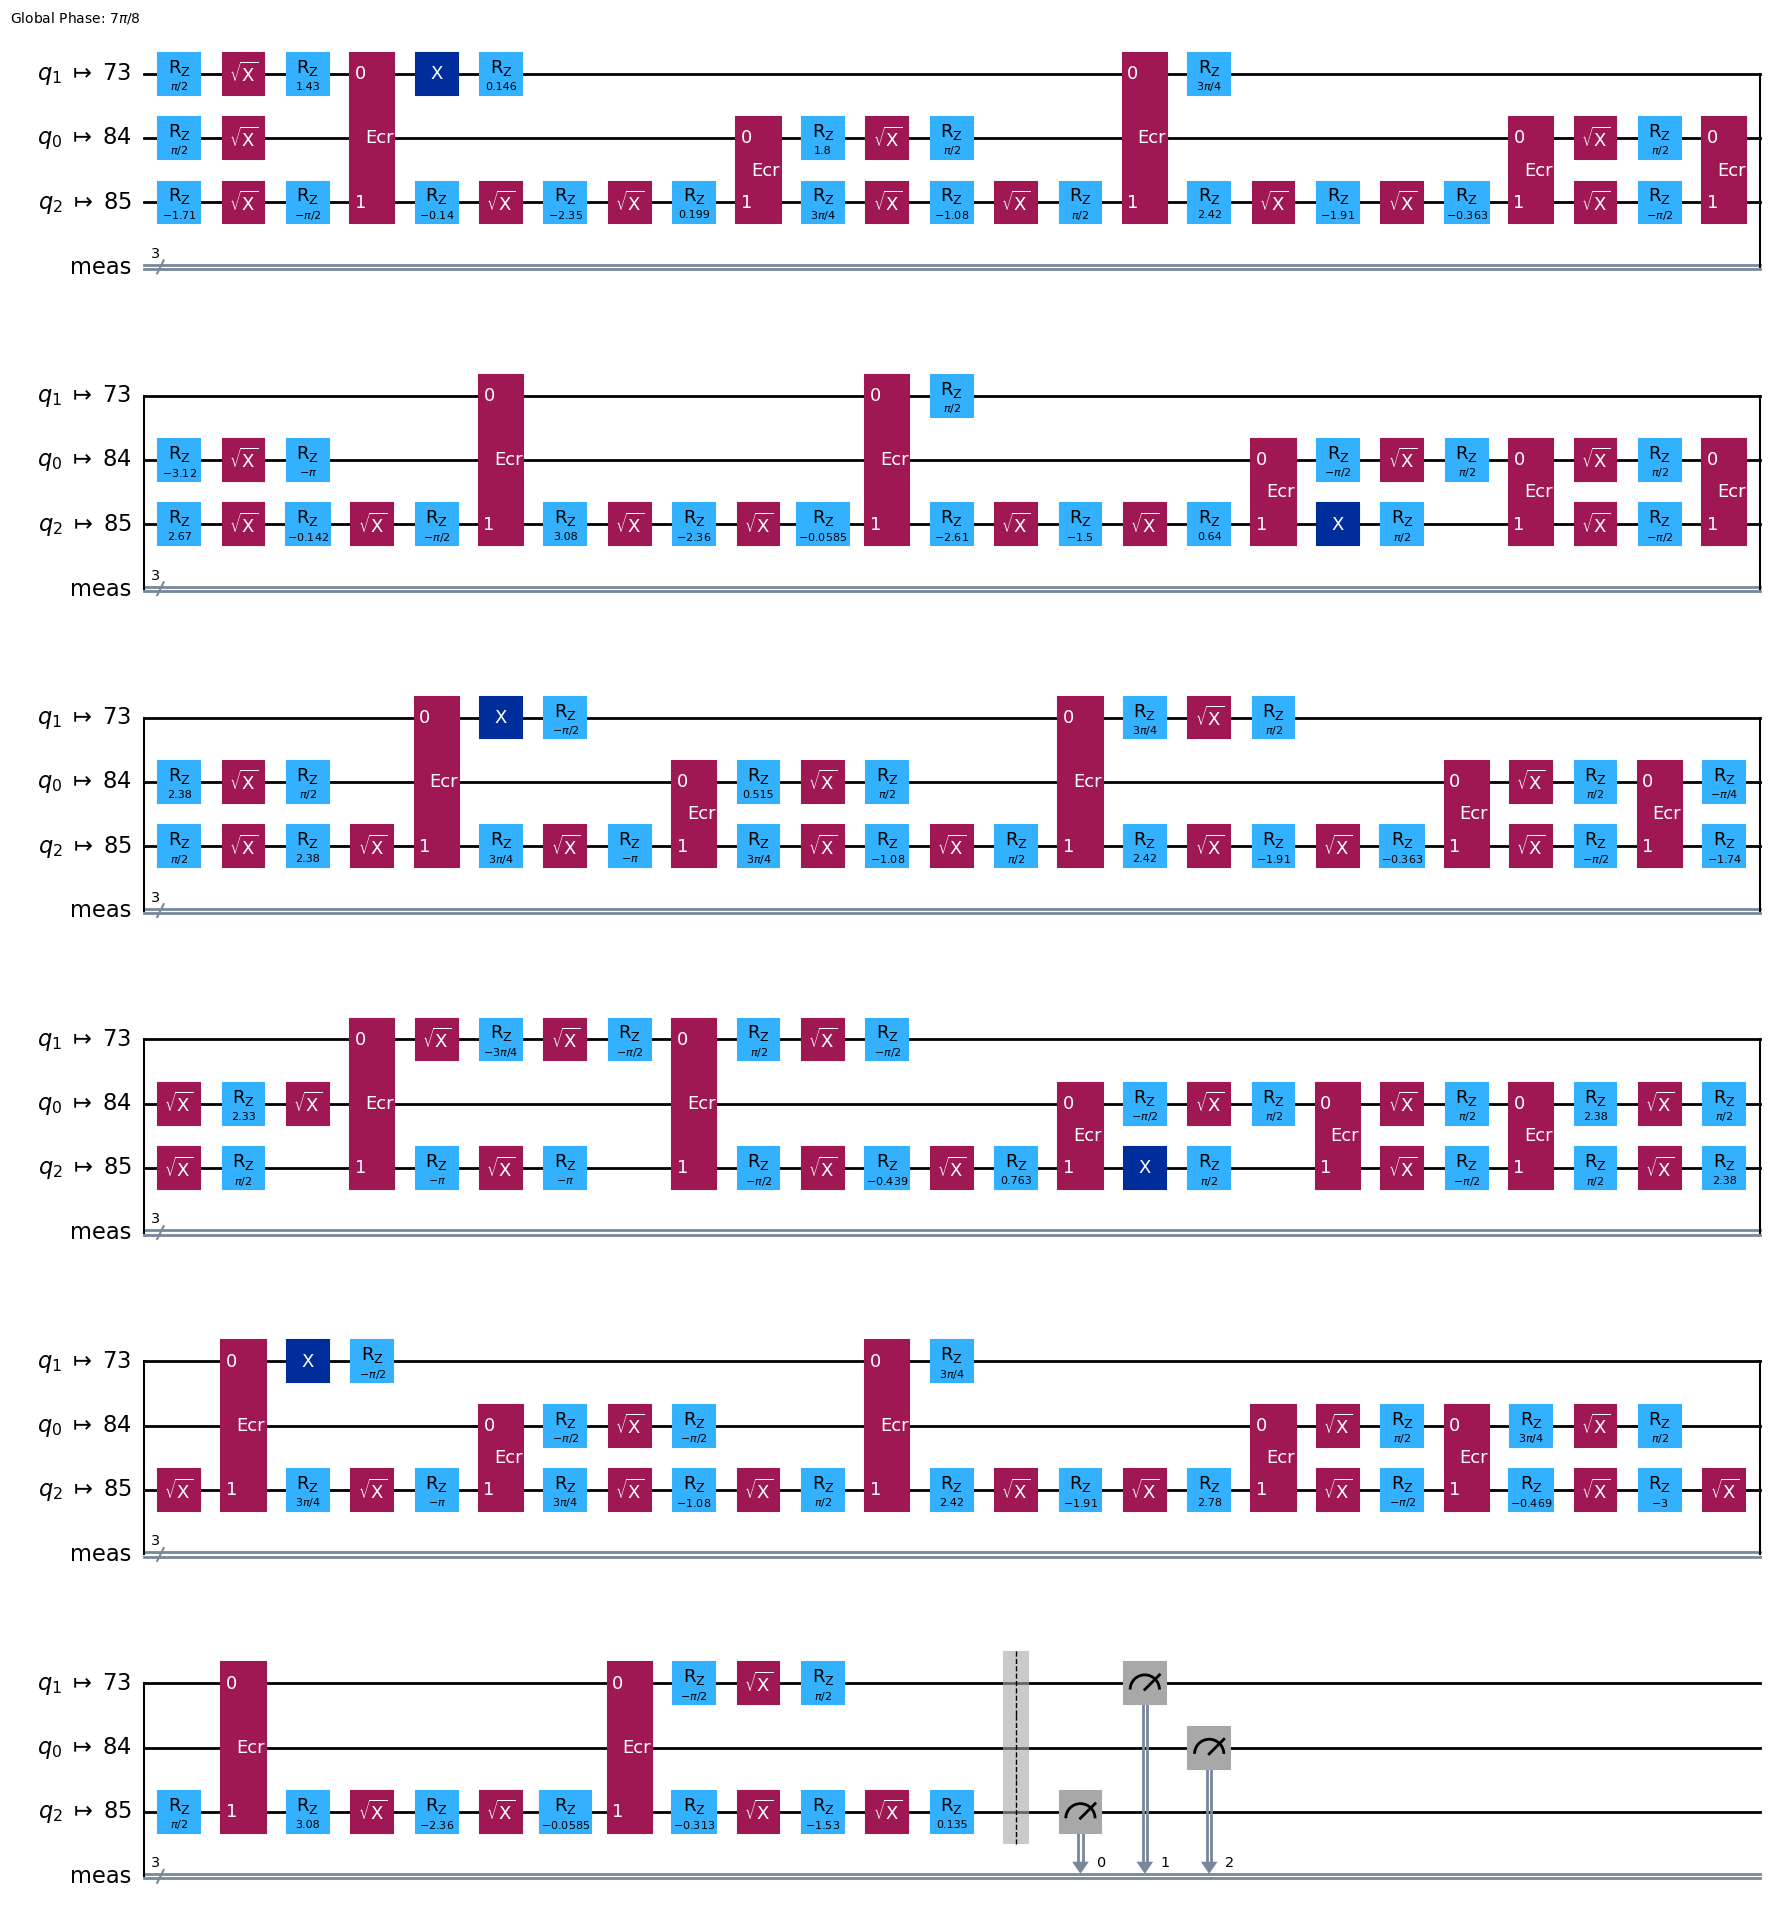

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## Step 3: Execute using Qiskit Primitives.

In [10]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

RuntimeInvalidStateError: 'Unable to retrieve result for job crah260gexag008mhz50. Job was cancelled.'

In [ ]:
plot_distribution(dist)